<a href="https://colab.research.google.com/github/Rogerio-mack/Ciencia-de-Dados-e-Aprendizado-de-Maquina/blob/main/ACD_T16_Recommentadion_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->

# Introdução aos Sistemas de Recomendação

Sistemas de Recomendação são bastante empregados no comércio eletrônico e você já deve ter recebido recomendações em um site de compras como a Amazon, ou ainda plataformas de conteúdo como o Spotify e NetFlix.

Em geral os Sistemas de Recomendação empregam dados dos usuários, itens e  feedback implícito (como o fato de tê-los comprado) ou explícito (como a avaliação ou ranking dos produtos para sugerir itens mais adequados ou prever a avaliação para todos os itens ainda não avaliados.




# Abordagens

Os sistemas de recomendação podem ser subdivididos em três categorias: 

* Sistemas baseados em conteúdo (Content-based filtering) 
* Sistemas de filtragem colaborativa (Collaborative filtering)
* Sistemas híbridos (que usam uma combinação dos outros dois)

A primeira abordagem baseia-se nas informações dos usuários ou dos produtos. A ideia é associar a um usuário a um grupo de usuários semelhantes para sugerir todos os itens bem avaliados pelos outros usuários, ou agrupar os produtos de acordo com suas características e propor um subconjunto de produtos semelhantes aos já consumidos pelo usuário. 

A segunda abordagem é mais sofisticada. Ela trabalha com classificações explícitas dos itens de cada usuário para prever esse valor para cada novo par item-usuário. Ela requer muito mais poder computacional (pense em todos os pares possíveis item-usuário), mas essa é a abordagem empregada hoje pela  maior parte dos sistemas de recomendação em tempo real (de modo híbrido) podendo o modelo ser retreinado ou atualizado diariamente. 

Os sistemas híbridos combinam resultados dos dois modelos e você pode imaginar muitas outras combinações combinando popularidade dos produtos, regras de associação etc.




# Supervisionado ou Não Supervisionado?

Essas diferentes abordagens e as diferentes formas que podem ser implementados os sistemas de recomendação permite encontrarmos sistemas tanto Supervisionados como não Supervisionados e, na maior parte dos casos, essa distinção para Sistemas de Recomendação faz pouco diferença. Como você verá a seguir, nossa primeira implementação é não Supervisionada, mas poderíamos ter empregado outras técnicas e o melhor, se necessária uma classificação é melhor analisar caso a caso.

![imagem](https://miro.medium.com/max/950/1*0ygb2uJknG6FdYT1vZqnsg.png)

![imagem](https://miro.medium.com/max/772/1*5z9o9XrN8QCkcVMYwxPHEQ.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random

# Sistemas baseados em conteúdo

Vamos considerar o seguinte conjunto de dados para construir modelos de Sistemas de Recomendação:

In [2]:
#@title RUN this setup before continue

items = pd.read_csv('http://meusite.mackenzie.br/rogerio/data_load/recommendation_spotify_items.csv',index_col=0,nrows=1000) # Lê somente 100 primeiros
random.seed(1984)
items = items.iloc[ sorted(random.sample(range(len(items)), 20)) ].reset_index() # Seleciona somente 20 itens
items = items.rename(columns={'index':'song_id'})

print('\n\nSong items: items')
print(180*'-')
display( items.head(4) )
print('\nitems.shape: ',items.shape)

users = pd.read_csv('http://meusite.mackenzie.br/rogerio/data_load/recommendation_users.csv',nrows=100,usecols=['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']) # Lê somente 100 primeiros
random.seed(1984)
users = users.iloc[ sorted(random.sample(range(len(users)), 10)) ].reset_index(drop=True) # Seleciona somente 10 users

print('\n\nUsers: users')
print(180*'-')
display( users.head(4) )
print('\nusers.shape: ',users.shape)

transactions = pd.DataFrame({'ID':[],'song_id':[]})
random.seed(1984)
for _ , row in users.iterrows():
  n_items = random.randint(1,4) # max 4 itens por usuário
  for item in random.sample(set(items.song_id), n_items):
    transactions = pd.concat([transactions, pd.DataFrame({'ID':[row.ID],'song_id':[item]})]) 

transactions.reset_index(drop=True,inplace=True)
for c in transactions: transactions[c] = transactions[c].astype('int')

print('\n\nTransactions: transactions')
print(180*'-')
display( transactions.head(4) )
print('\ntransactions.shape: ',transactions.shape)





Song items: items
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,song_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,51,0.0638,0.700,224480,0.840,0.112000,7,0.1410,-6.227,0,0.0292,132.475,4.0,0.745,1,The Chase,Future Islands
1,72,0.5180,0.683,155133,0.708,0.000021,4,0.1750,-6.852,0,0.0289,106.446,4.0,0.967,1,Spooky,Dusty Springfield
2,176,0.1410,0.500,256093,0.593,0.000006,1,0.0969,-4.340,1,0.0898,68.456,4.0,0.325,1,New Slaves,Kanye West
3,221,0.0696,0.512,287147,0.821,0.330000,9,0.0998,-7.442,0,0.0334,149.988,4.0,0.396,1,Light House,Future Islands



items.shape:  (20, 17)


Users: users
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,ID,SEX,EDUCATION,MARRIAGE,AGE
0,10,1,3,2,35
1,28,2,3,2,30
2,32,1,2,2,33
3,40,1,1,2,31



users.shape:  (10, 5)


Transactions: transactions
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,ID,song_id
0,10,869
1,10,72
2,10,826
3,28,347



transactions.shape:  (26, 2)


## Popularidade

O sistema mais ingênuo pode simplesmente recomendar a todos os usuários o produto mais vendido. É o critério da popularidade.

In [3]:
transactions.song_id.value_counts()

883    4
506    3
347    2
313    2
176    2
72     2
869    2
249    1
221    1
826    1
726    1
913    1
889    1
653    1
679    1
282    1
Name: song_id, dtype: int64

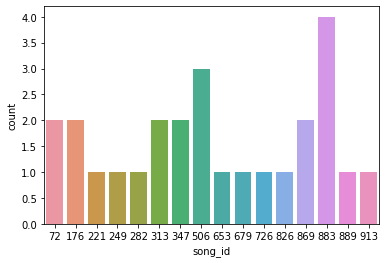

In [4]:
sns.countplot(x=transactions.song_id)
plt.show()

In [5]:
transactions.song_id.mode()[0]

883

In [6]:
print('Suggested items:')
print(items[ items.song_id == transactions.song_id.mode()[0] ][ ['song_title','artist'] ])

Suggested items:
                            song_title        artist
17  Something About You - Extended Mix  Hayden James


Embora ainda empregado, esse tipo de recomendação talvez tenha pouca efetividade, e não personaliza a recomendação para qualquer usuário. De fato, há muito pouca inteligência nessa forma de recomendação.

# Filtro de Conteúdo por Usuário

Podemos obter algo melhor buscando produtos positivamente avaliados ou que são mais comprados por usuários que sejam *semelhantes* ao usuário que queremos fazer uma recomendação. Para encontrar esses usuários *semelhantes* podemos empregar uma aprendizagem não supervisionada de vizinhos mais próximos, e é o que fazemos a seguir com a função `NearestNeighbors` e você deve ter cuidado para não confundir com o classificador de k-vizinhos mais próximos (`KNeighborsClassifier`). O classificador é um modelo supervisionado enquanto, aqui, empregamos um modelo mais próximo da clusterização, um modelo não supervisionado. 

In [7]:
from sklearn.neighbors import NearestNeighbors

# Fit k-nearest neighbors
X = users.drop(columns='ID')

n_neighbors = 3 

knn = NearestNeighbors(n_neighbors=n_neighbors+1)
knn.fit(X)

# Select a user
random.seed(1894)
print('\nEscolha de um user aleatório...\n')
user_selected = users[ users.ID == random.sample(set(users.ID), 1)[0] ].drop(columns='ID')

# Determine the neighbors
d, neighbors = knn.kneighbors(user_selected)
neighbors = neighbors[0][1::] 
d = d[0][1::] 

neighbors_ids = users.iloc[ neighbors ].ID

print('user_selected:')
print(user_selected)
print('Neighbors:')
print(neighbors)
print('Distance:')
print(d)
print('Neighbors_ids:')
print(neighbors_ids)

    


Escolha de um user aleatório...

user_selected:
   SEX  EDUCATION  MARRIAGE  AGE
8    2          1         2   26
Neighbors:
[6 5 1]
Distance:
[2.23606798 4.         4.47213595]
Neighbors_ids:
6    50
5    47
1    28
Name: ID, dtype: int64


**CUIDADO** Note que empregamos $k+1$ vizinhos e eliminamos o primeiro encontrado. Experimente modificar o programa acima e explicar, por quê?

Double-click **aqui** para ver a resposta.
<!-- Resposta:

O primeiro vizinho mais próximo é o próprio elemento com distância zero. Lembre-se que poderiam haver elementos idênticos queremos eliminar apenas o próprio elemento. Aqui, por simplicidade e não havendo elementos idênticos podemos apenas eliminar o primeiro da lista.
-->

Com base nos usuários semelhantes que você obteve podemos buscar os itens adquiridos por eles e sugerir esses produtos ao usuário selecionado.

In [8]:
# Determine the suggested items
suggested_items = []

for u in neighbors_ids:
  for item in transactions[ transactions.ID == u ].song_id:
     if item not in suggested_items:
          suggested_items.append(item)

print('Suggested items:')
print(suggested_items)
print('Suggested items:')
print(items[ items.song_id.isin(suggested_items) ][ ['song_title','artist'] ])


Suggested items:
[313, 889, 221, 726, 506, 347, 913]
Suggested items:
                                          song_title          artist
3                                        Light House  Future Islands
6                                     Had Ten Dollaz  Cherry Glazerr
7                                           Pacifier      Young Thug
10                               The Kids Were Wrong     Memoryhouse
13                                              Open            Rhye
18                                    All I Wanna Do  The Beach Boys
19  Bizarre Love Triangle - Shep Pettibone 12" Remix       New Order


E poderíamos ainda aplicar outros filtros como, por exemplo, estabelecer um número mínimo de vezes que a música foi ouvida pelos usuários, as mais recentemente ouvidas ou de artistas que já tenham sido ouvidos pelo usuário selecionado. As possibilidades são inúmeras.

# Filtro de Conteúdo por Item

No Filtro de Conteúdo por Usuário buscamos usuários semelhantes e, então, selecionamos itens desses usuários para sugerir itens a um usuário selecionado. Podemos também buscar diretamente itens semelhantes aos que foram consumidos pelo usuário selecionado aplicando a mesma técnica de empregar uma aprendizagem não supervisionada de vizinhos mais próximos,com a função `NearestNeighbors`.

Essas são as caraterísticas de uma música, um item consumido:

In [9]:
items.columns

Index(['song_id', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

E podemos definir um item consumido por um usuário, uma música recentemente ou ouvida, ou podemos ainda querer sugerir músicas semelhantes a todos os usuários que tenham ouvido uma determinada faixa.


In [10]:
users.iloc[8]

ID           82
SEX           2
EDUCATION     1
MARRIAGE      2
AGE          26
Name: 8, dtype: int64

In [11]:
print('\nEscolha da primeira faixa do usuário anterior...\n')
item_selected = items[ items.song_id == transactions[ transactions.ID == users.iloc[8].ID ].song_id.values[0] ]
  
item_selected


Escolha da primeira faixa do usuário anterior...



,song_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
17,883,0.198,0.89,326318,0.52,0.273,2,0.0638,-6.927,0,0.187,114.959,4.0,0.717,1,Something About You - Extended Mix,Hayden James


In [12]:
from sklearn.neighbors import NearestNeighbors

# Fit k-nearest neighbors
X = items[['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']]

n_neighbors = 3 

# metrics = ['euclidean', 'hamming', 'jaccard']
knn = NearestNeighbors(n_neighbors=n_neighbors+1, radius=2.0) # , metrics = metrics[0]
knn.fit(X)

# Select a song from a user
random.seed(1894)
item_selected = items[ items.song_id == transactions[ transactions.ID == random.sample(set(users.ID), 1)[0] ].song_id.values[0] ]
item_selected = item_selected[['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']]

# Determine the neighbors
d, neighbors = knn.kneighbors(item_selected)
neighbors = neighbors[0][1::] 
d = d[0][1::] 

neighbors_ids = items.iloc[ neighbors ].song_id

print('item_selected:')
print(item_selected)
print('Neighbors:')
print(neighbors)
print('Distance:')
print(d)
print('Neighbors_ids:')
print(neighbors_ids)

    

item_selected:
    acousticness  danceability  duration_ms  ...    tempo  time_signature  valence
17         0.198          0.89       326318  ...  114.959             4.0    0.717

[1 rows x 13 columns]
Neighbors:
[16 15  3]
Distance:
[  189.25936697 32467.11289657 39171.0162962 ]
Neighbors_ids:
16    869
15    826
3     221
Name: song_id, dtype: int64


Agora os vizinhos são escolhidos entre as faixas, os itens, e selecionamos as faixas próximas.

In [13]:
# Determine the suggested items
suggested_items2 = neighbors_ids

print('Suggested items:')
print(suggested_items2)
print('Suggested items:')
print(items[ items.song_id.isin(suggested_items2) ][ ['song_title','artist'] ])


Suggested items:
16    869
15    826
3     221
Name: song_id, dtype: int64
Suggested items:
                         song_title            artist
3                       Light House    Future Islands
15               Living Every Dream            Antwon
16  Nobodys Fool - Ben Pearce Remix  Real Connoisseur


# Mixed...

Novamente as possibilidades de filtros são muitas. Você pode por exemplo estabelecer um número mínimo de ouvintes para recomendar uma faixa, ou empregar faixas mais recentes. Apenas para ilustrar essas inúmeras possibilidades vamos fazer a intersecção dos filtros de usuário e de contéudo que fizemos antes.

In [14]:
# Determine the suggested items
suggested_items3 = set(suggested_items).intersection(set(suggested_items2))

print('Suggested items:')
print(suggested_items3)
print('Suggested items:')
print(items[ items.song_id.isin(suggested_items3) ][ ['song_title','artist'] ])

Suggested items:
{221}
Suggested items:
    song_title          artist
3  Light House  Future Islands


Que é uma faixa que não está na lista das ouvidas do usuário selecionado! Ótima recomendação!!!

In [15]:
transactions[ transactions.ID == 82 ]

,ID,song_id
21,82,883
22,82,249
23,82,506


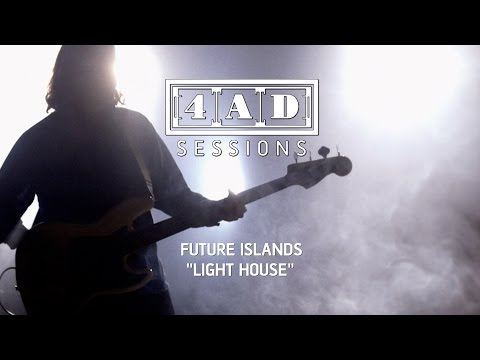

In [16]:
from IPython.display import YouTubeVideo
YouTubeVideo('VFUZDXIRdlo')

# Collaborative Filtering

Os sistemas de filtragem colaborativa usam as ações dos usuários para recomendar itens. Eles empregam uma matriz de ações dos usuários, como uma a avaliação dos itens, pelos itens. Por exemplo, podemos ter uma matriz de *ranking* de $m$ itens para $n$ usuários:

![imagem](https://production-media.paperswithcode.com/thumbnails/task/task-0000000592-2508deea.jpg)

Do mesmo modo que nos modelos anteriores podemos então buscar usuários, ou itens, semelhantes agora que temos vetores para ambas as dimensões e, dependendo da dimensão empregada teremos **user-based collaborative filtering** ou  **item-based collaborative filtering**. Por exemplo, o item-based filtering é bastante semelhante ao sistema de recomendação de conteúdo que construímos antes. Eles identificam itens semelhantes com base em como as pessoas os classificaram no passado usando isso como características dos produtos. Por exemplo, se Adriana e Daniel deram 5 estrelas para a música Hey Jude e Strawberry Fields Forever o sistema identifica esses itens como semelhantes e alguém que ouvir Hey Jude poderá receber a recomendação de Strawberry Fields Forever.

A filtragem colaborativa baseada em itens foi desenvolvida pela Amazon. Em um sistema onde há mais usuários do que itens, a filtragem com base em itens é mais rápida e estável do que com base no usuário. Embora a classificação por usuário parece ser mais efetiva para sistemas de entretenimento (música, filmes etc.).

In [17]:
#@title RUN this setup before continue

ratings = pd.DataFrame({'ID':[],'song_id':[],'rating':[]})

random.seed(1984)
for _ , row in users.iterrows():
  n_items = random.randint(1,3) # max 3 itens por usuário
  for item in random.sample(set(items.song_id), n_items):
    ratings = pd.concat([ratings, pd.DataFrame({'ID':[row.ID],'song_id':[item],'rating':[random.randint(1,5)]})]) 

ratings.reset_index(drop=True,inplace=True)
for c in ratings: ratings[c] = ratings[c].astype('int')

ratings.head()

,ID,song_id,rating
0,10,869,3
1,10,72,2
2,28,347,3
3,28,913,1
4,28,51,2


Com base nas avaliações dos usuários acima podemos construir a matriz de ranking.

In [18]:
df_ratings = ratings.pivot(
    index='song_id',
    columns='ID',
    values='rating'
).fillna(0)

df_ratings

ID,10,28,32,40,44,47,50,64,82,100
song_id,,,,,,,,,,
51,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0
221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
313,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
347,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
506,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0
679,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
726,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


Você pode notar que ela será sempre uma matriz bastante esparsa e suas dimensões podem ser realmente um problema mesmo para um pequeno número de itens e usuários. Como apenas $1000$ itens e $1000$ usuários chegamos a uma matriz de com $10^{6}$, ou um milhão de elementos. O que ocorreria então em um sistema como o da Amazon ou Netflix com milhões de usuários e milhares de itens? Você verá isso logo mais adiante.

A música *Pacifier*, pode ser agora identificada com as seguintes características, 

In [19]:
items[items.song_id == 347]

,song_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
7,347,0.0469,0.766,237867,0.82,0.0,2,0.336,-5.851,1,0.124,117.012,4.0,0.401,1,Pacifier,Young Thug


In [20]:
df_ratings[ df_ratings.index == 347 ]

ID,10,28,32,40,44,47,50,64,82,100
song_id,,,,,,,,,,
347,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


E podemos então buscar as músicas *semelhantes* empregando o mesmo método de vizinhos mais próximos que empregamos anteriormente,

In [21]:
from sklearn.neighbors import NearestNeighbors

# Fit k-nearest neighbors
X = df_ratings

n_neighbors = 3 

# metrics = ['euclidean', 'hamming', 'jaccard']
knn = NearestNeighbors(n_neighbors=n_neighbors+1, radius=2.0) # , metrics = metrics[0]
knn.fit(X)

# Select a song from a user
random.seed(1894)
df_ratings_selected = df_ratings[ df_ratings.index == 347 ]

# Determine the neighbors
d, neighbors = knn.kneighbors(df_ratings_selected)
neighbors = neighbors[0][1::] 
d = d[0][1::] 

neighbors_ids = items.iloc[ neighbors ].song_id

print('item_selected:')
print(item_selected)
print('Neighbors:')
print(neighbors)
print('Distance:')
print(d)
print('Neighbors_ids:')
print(neighbors_ids)

item_selected:
    acousticness  danceability  duration_ms  ...    tempo  time_signature  valence
17         0.198          0.89       326318  ...  114.959             4.0    0.717

[1 rows x 13 columns]
Neighbors:
[9 0 7]
Distance:
[5.09901951 5.09901951 5.38516481]
Neighbors_ids:
9    395
0     51
7    347
Name: song_id, dtype: int64


In [22]:
# Determine the suggested items
suggested_items4 = neighbors_ids

print('Suggested items:')
print(suggested_items4)
print('Suggested items:')
print(items[ items.song_id.isin(suggested_items4) ][ ['song_title','artist'] ])

Suggested items:
9    395
0     51
7    347
Name: song_id, dtype: int64
Suggested items:
  song_title            artist
0  The Chase    Future Islands
7   Pacifier        Young Thug
9       5ft7  Tonstartssbandht


Neste ponto pode ser importante ressaltarmos que, por se tratar de uma introdução, estamos fazendo uma série de simplificações. Por exemplo não estamos discutindo outras métricas de distância que são empregadas e, talvez interesse saber que a similiridade *cosseno* é nesses casos muito mais comum de ser empregada que a distância euclidiana e que ainda existem outras formas de medir similaridade e distância. Também não tratamos aqui de algumas técnicas para calcular os valores de ranking que, aqui, foram obtidos de forma simples a partir da avaliação direta dos usuários de 1-5. Você pode encontrar uma referência rápida para saber mais [aqui](https://realpython.com/build-recommendation-engine-collaborative-filtering/). 

# Baseado em modelo

Um modo de lidar com o problema da alta dimensionalidade da matriz acima consiste em obtermos uma redução de dimensionalidade o que pode melhorar o desempenho do algoritmo em termos de espaço e tempo. Você pode usar vários métodos como fatoração matricial ou autoencodificador para fazer isso.

Você pode entender a fatoração matricial como a quebra de uma grande matriz em um produto de menores, algo semelhante à fatorização dos números inteiros ($12 = 3 \times 2 \times 2$). No caso de matrizes, uma matriz $A$ de dimensão $m \times n$ pode ser reduzida ao produto de duas matrizes $X$ e $Y$ com dimensões  $m \times d$ e $d \times n$

![imagem](https://files.realpython.com/media/dimensionality-reduction.f8686dd52b9c.jpg)

As matrizes reduzidas realmente representam os usuários e itens individualmente. 

![image,](https://cdn-images-1.medium.com/max/800/0*sk4ng-D6cKW_HOT8.)

As linhas m na primeira matriz representam os usuários m, e as colunas d lhe contam sobre os recursos ou características dos usuários. O mesmo vale para a matriz de itens com n itens e características d. 

As duas colunas na matriz de usuário e as duas linhas na matriz de itens são chamadas de **fatores latentes** e são uma indicação de características ocultas sobre os usuários ou os itens. 

O número de fatores latentes afeta as recomendações de forma que quanto maior o número de fatores, mais personalizadas as recomendações se tornam. Mas muitos fatores podem levar a um excesso de adaptação no modelo (sobreajuste), mas a melhor determinação do número de fatores latentes está além do que podemos tratar em uma introdução ao tema.








# Algoritmos para Factorização Matricial

Um dos algoritmos mais populares para fatorar uma matriz é o **algoritmo de decomposição de valor singular** ou **SVD**, um método que ganhou fama ao empregado em sistemas de recomendação da Netflix, embora existam hoje outros algoritmos que incluem de diferentes variações do PCA a autoencodificadores de  Redes Neurais.

Aqui vamos empregar o algoritmo SVD no problema anterior reduzindo as 10 características das trilhas musicais para 3.

In [21]:
df_ratings.shape

(14, 10)

In [23]:
np.matrix(df_ratings)

matrix([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 4., 0., 0., 3., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 4., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0., 0., 0., 0., 0., 5.],
        [0., 0., 0., 0., 5., 0., 0., 3., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 5., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 4., 0., 4.],
        [3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 4., 0., 5., 0., 5., 5., 0., 0.],
        [0., 0., 0., 0., 0., 3., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [24]:
import sklearn
from sklearn.decomposition import TruncatedSVD

matrix_ratings = np.matrix(df_ratings)
SVD = TruncatedSVD(n_components=3, random_state=1984)
matrix = SVD.fit_transform(matrix_ratings)
matrix.shape

(14, 3)

In [25]:
matrix

array([[ 2.66894475e-02,  6.84017096e-01, -9.29976365e-02],
       [ 5.70235306e-17,  6.53045698e-16, -2.71447461e-16],
       [ 1.32609673e+00, -1.67764610e-01,  4.21612139e+00],
       [-5.80953054e-18,  6.20565840e-17, -5.41656080e-16],
       [-6.28363686e-16,  1.40684735e-15,  8.87330779e-15],
       [ 5.56027467e-01,  5.37412688e+00, -4.30927087e-01],
       [ 5.03316005e+00, -5.76205291e-01, -2.33761734e+00],
       [ 1.90671845e-01,  9.13998132e-01,  1.10466431e+00],
       [ 3.38432712e+00, -1.25939745e+00, -2.35085881e+00],
       [ 2.61123854e+00,  4.38940386e+00, -2.15489216e-01],
       [ 7.85617760e-17, -4.30212236e-16,  1.85090002e-16],
       [ 9.18093206e+00, -7.91010966e-01,  1.60391862e+00],
       [-4.72853898e-16,  1.05772273e-15,  6.77425971e-15],
       [ 1.33447237e-02,  3.42008548e-01, -4.64988182e-02]])

Agora a música Pacifier, é a 5a da lista e pode ser agora identificada com o seguinte vetor característico,

In [26]:
df_ratings.index

Int64Index([51, 72, 176, 221, 313, 347, 506, 679, 726, 797, 869, 883, 889,
            913],
           dtype='int64', name='song_id')

In [34]:
df_ratings.index.to_list().index(347)

5

In [42]:
matrix[df_ratings.index.to_list().index(347),:].reshape(1, -1) 

array([[ 0.55602747,  5.37412688, -0.43092709]])

Do mesmo modo que antes vamos identificar os seus vizinhos mais próximos,

In [43]:
from sklearn.neighbors import NearestNeighbors

# Fit k-nearest neighbors
X = matrix

n_neighbors = 3 

# metrics = ['euclidean', 'hamming', 'jaccard']
knn = NearestNeighbors(n_neighbors=n_neighbors+1, radius=2.0) # , metrics = metrics[0]
knn.fit(X)

# Select a song from a user
random.seed(1894)

# ValueError: Expected 2D array, got 1D array instead:
# array=[ 0.55602747  5.37412688 -0.43092709].
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
df_ratings_selected = matrix[df_ratings.index.to_list().index(347),:].reshape(1, -1)  

# Determine the neighbors
d, neighbors = knn.kneighbors(df_ratings_selected)
neighbors = neighbors[0][1::] 
d = d[0][1::] 

neighbors_ids = items.iloc[ neighbors ].song_id

print('item_selected:')
print(item_selected)
print('Neighbors:')
print(neighbors)
print('Distance:')
print(d)
print('Neighbors_ids:')
print(neighbors_ids)

item_selected:
    acousticness  danceability  duration_ms  ...    tempo  time_signature  valence
17         0.198          0.89       326318  ...  114.959             4.0    0.717

[1 rows x 13 columns]
Neighbors:
[9 7 0]
Distance:
[2.28910145 4.73120218 4.73196838]
Neighbors_ids:
9    395
7    347
0     51
Name: song_id, dtype: int64


In [45]:
# Determine the suggested items
suggested_items5 = neighbors_ids

print('Suggested items:')
print(suggested_items5)
print('Suggested items:')
print(items[ items.song_id.isin(suggested_items5) ][ ['song_title','artist'] ])

Suggested items:
9    395
7    347
0     51
Name: song_id, dtype: int64
Suggested items:
  song_title            artist
0  The Chase    Future Islands
7   Pacifier        Young Thug
9       5ft7  Tonstartssbandht


Nenhuma supresa talvez em encontrarmos a banda *Future Islands* novamente...